In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import plotly.express as ex

from tqdm.cli import tqdm
from glob import glob
from sklearn.manifold import TSNE

from os import path as pathlib,walk

%matplotlib inline

In [5]:
class Dataset(object):
    """
    Dataset wrapper to read images from folder and structure it.
    """
    def __init__(self,path,n_faces,resize=110):
        self.path = pathlib.abspath(path)
        self.resize = resize

    def __repr__(self,):
        return f"Dataset Parser @ {self.path}"
        
    def parse(self,progress_bar=True):
        w = walk(self.path)
        self.data = np.array([[[r,pathlib.join(r,f_)] for f_ in f] for r,_,f in list(w)[1:]]).reshape(-1,2)
        self.y = np.array(self.data[:,0])
        self.x = np.array([
            cv2.cvtColor(
                cv2.resize(
                    cv2.imread(
                        i
                    ),
                    (self.resize,self.resize)
                ),
                cv2.COLOR_BGR2RGB
            ) / 255
            for 
                i
            in 
                (tqdm(self.data[:,1]) if progress_bar else self.data[:,1])
        ]).astype(np.float32)
        return self
            

In [6]:
dataset = Dataset("./images/train/",100)

In [7]:
dataset.parse(progress_bar=1)

100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1558.47it/s]


Dataset Parser @ C:\workspace\facenet_mini\notebooks\images\train

In [8]:
dataset

Dataset Parser @ C:\workspace\facenet_mini\notebooks\images\train

In [9]:
# train = np.array([[i.split("-")[0].split("\\")[-1],i] for i in glob("images\\train\\*")])
# y,x = train[:,0],train[:,1]
# x = np.array([cv2.cvtColor(cv2.imread(i),cv2.COLOR_BGR2RGB) for i in list(x)])
# x = (x / 255).astype(np.float32)

In [10]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,Callback

### Base Network

<!-- |layer  | size-in    | size-out   | kernel     | param | FLPS |
|-------|------------|------------|------------|-------|------|
|conv1  | 220×220×3  | 110×110×64 | 7×7×3, 2   | 9K    |115M  |
|pool1  | 110×110×64 | 55×55×64   | 3×3×64, 2  | 0     |      |
|rnorm1 | 55×55×64   | 55×55×64   | 0          |       |      |
|conv2a | 55×55×64   | 55×55×64   | 1×1×64, 1  | 4K    | 13M  |
|conv2  | 55×55×64   | 55×55×192  | 3×3×64, 1  | 111K  | 335M |
|rnorm2 | 55×55×192  | 55×55×192  | 0          |       |      |
|pool2  | 55×55×192  | 28×28×192  | 3×3×192, 2 | 0     |      |
|conv3a | 28×28×192  | 28×28×192  | 1×1×192, 1 | 37K   | 29M  |
|conv3  | 28×28×192  | 28×28×384  | 3×3×192, 1 | 664K  | 521M |
|pool3  | 28×28×384  | 14×14×384  | 3×3×384, 2 | 0     |      |
|conv4a | 14×14×384  | 14×14×384  | 1×1×384, 1 | 148K  | 29M  |
|conv4  | 14×14×384  | 14×14×256  | 3×3×384, 1 | 885K  | 173M |
|conv5a | 14×14×256  | 14×14×256  | 1×1×256, 1 | 66K   | 13M  |
|conv5  | 14×14×256  | 14×14×256  | 3×3×256, 1 | 590K  | 116M |
|conv6a | 14×14×256  | 14×14×256  | 1×1×256, 1 | 66K   | 13M  |
|conv6  | 14×14×256  | 14×14×256  | 3×3×256, 1 | 590K  | 116M |
|pool4  | 14×14×256  | 7×7×256    | 3×3×256, 2 | 0     |      |
|concat | 7×7×256    | 7×7×256    | 0          |       |      |
|fc1    | 7×7×256    | 1×32×128   | maxout p=2 | 103M  | 103M |
|fc2    | 1×32×128   | 1×32×128   | maxout p=2 | 34M   | 34M  |
|fc7128 | 1×32×128   | 1×1×128    | 524K 0.5M  |       |      |
|L2     | 1×1×128    | 1×1×128    | 0          |       |      | -->

In [11]:
d = 32

In [12]:
def base_network(d=d):

    _input = Input(shape=(110,110,3))

    a_conv0 = Conv2D(32,3,activation="relu",padding="same")(_input)
    a_conv1 = Conv2D(32,3,activation="relu",padding="same")(a_conv0)
    a_conv2 = Conv2D(32,3,activation="relu",padding="same")(a_conv1)
    a_conc = concatenate([a_conv0,a_conv2,a_conv2])
    a_pool = MaxPool2D()(a_conc)

    b_conv0 = Conv2D(32,3,activation="relu",padding="same")(a_pool)
    b_conv1 = Conv2D(32,3,activation="relu",padding="same")(b_conv0)
    b_conv2 = Conv2D(32,3,activation="relu",padding="same")(b_conv1)
    b_conc = concatenate([a_pool,b_conv0,b_conv2,b_conv2])
    b_pool = MaxPool2D()(b_conc)

    c_conv0 = Conv2D(64,3,activation="relu",padding="same")(b_pool)
    c_conv1 = Conv2D(64,3,activation="relu",padding="same")(c_conv0)
    c_conv2 = Conv2D(64,3,activation="relu",padding="same")(c_conv1)
    c_conc = concatenate([b_pool,c_conv0,c_conv2,c_conv2])
    c_pool = MaxPool2D()(c_conc)

    d_conv0 = Conv2D(64,3,activation="relu",padding="same")(c_pool)
    d_conv1 = Conv2D(64,3,activation="relu",padding="same")(d_conv0)
    d_conv2 = Conv2D(64,3,activation="relu",padding="same")(d_conv1)
    d_conc = concatenate([c_pool,d_conv0,d_conv2,d_conv2])
    d_pool = MaxPool2D()(d_conc)

    e_conv0 = Conv2D(128,3,activation="relu",padding="same")(d_pool)
    e_conv1 = Conv2D(128,3,activation="relu",padding="same")(e_conv0)
    e_conv2 = Conv2D(128,3,activation="relu",padding="same")(e_conv1)
    e_conv3 = Conv2D(128,3,activation="relu",padding="same")(e_conv2)
    e_conc = concatenate([d_pool,e_conv0,e_conv1,e_conv2,e_conv3])
    e_pool = MaxPool2D()(e_conc)

    f_conv0 = Conv2D(256,3,activation="relu",padding="same")(e_pool)
    f_conv1 = Conv2D(256,3,activation="relu",padding="same")(f_conv0)
    f_conv2 = Conv2D(256,3,activation="relu",padding="same")(f_conv1)
    f_conv3 = Conv2D(256,3,activation="relu",padding="same")(f_conv2)
    f_conc = concatenate([f_conv0,f_conv1,f_conv2,f_conv3])
    f_pool = MaxPool2D()(f_conc)

    dense = Flatten()(f_pool)
    dense = Dense(512,activation="linear")(dense)
    dense = Dense(d,activation="tanh")(dense)

    dense = tf.multiply(dense,32)
    
    model = keras.Model(_input,dense)
    return model

### Pairs

In [13]:
class Pairs(object):
    def __init__(self,model,x,y):
        assert len(x) == len(y)
        self.x = x.reshape(-1,*x[0].shape[:2],3)
        self.y = y
        self.model = model
        self.dummy = np.array([[0]])
        
    def get_pair(self,e,x,y):
        a = x.reshape(1,110,110,3)
        
        p_index = np.where(self.y == y)
        n_index = np.where(self.y != y)

        p = self.epoch_enc[p_index]
        n = self.epoch_enc[n_index]

        p_dist = np.sum(np.square(p - e),axis=1).argmax()
        n_dist = np.sum(np.square(n - e),axis=1).argmin()

        p = self.x[p_index][p_dist].reshape(1,110,110,3)
        n = self.x[n_index][n_dist].reshape(1,110,110,3)
        
        return np.array([a,p,n])
        
    def flow(self,epochs=1):
        for epoch in range(epochs):
            self.epoch_enc = self.model.predict(self.x,batch_size=600)
            _iter = zip(self.epoch_enc,self.x,self.y)#,total=len(self.epoch_enc))
            this_batch = np.array([self.get_pair(e,x,y) for e,x,y in _iter])
            for a,p,n in this_batch:
                yield (a,p,n),self.dummy

<!-- class Pairs(tf.Module):
        def __init__(self,net,x,y):
            self.net = net
            self.x = tf.constant(x.reshape(-1,*x[0].shape[:2],1).copy(),tf.float32)
            self.y = tf.constant(y.copy(),tf.uint8)       
            self.y_ = tf.argmax(self.y,axis=1)
            self.range_tensor = tf.range(0,len(x),dtype=tf.int32)
            self.dummy = tf.constant([[0]],dtype=tf.float32)
            
        def __repr__(self,):
            return "Pairs Generator"
            
        @tf.function
        def l2(self,x,y):
            return tf.square(tf.subtract(x,y))
        
        @tf.function
        def get_pair(self,i):
            
            x = tf.slice(self.x,[i,0,0,0],[1,-1,-1,-1])
            y = tf.slice(self.y_,[i],[1])
            e = tf.slice(self.epoch_emb,[i,0],[1,-1])
    
            p_index = tf.equal(y,self.y_)
            n_index = tf.not_equal(y,self.y_)
    
            p_dist = self.epoch_emb[p_index]
            n_dist = self.epoch_emb[n_index]
    
            p = tf.argmax(tf.reduce_sum(tf.square(tf.subtract(e,p_dist)),axis=1))
            n = tf.argmin(tf.reduce_sum(tf.square(tf.subtract(e,n_dist)),axis=1))
            
            p = tf.expand_dims(self.x[p_index][p],0)
            n = tf.expand_dims(self.x[n_index][n],0)
    
            return (x,p,n),self.dummy
        
        def flow(self,epochs):
            for epoch in range(epochs):
                self.epoch_emb = tf.constant(self.net.predict(self.x,batch_size=512),tf.float32)
                for i in self.range_tensor:
                    yield self.get_pair(i)
                    " -->

In [14]:
model = base_network()
pairs = Pairs(model,dataset.x,dataset.y)

In [15]:
flow = pairs.flow(1)

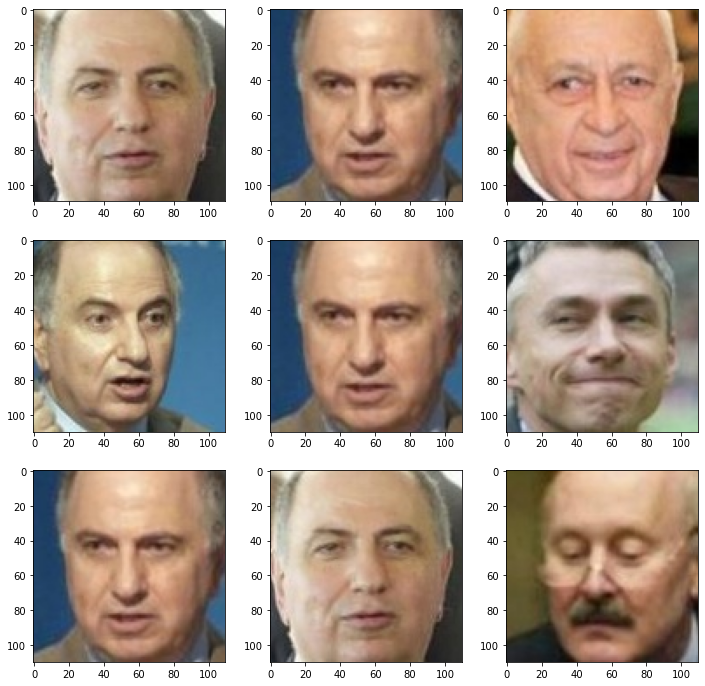

In [16]:
fig,axes = plt.subplots(3,3,figsize=(12,12))

for ax in axes:
    (a,p,n),r = next(flow)
    ax[0].imshow(a.reshape(110,110,3))
    ax[1].imshow(p.reshape(110,110,3))
    ax[2].imshow(n.reshape(110,110,3))

### Triplet Loss

### Triplet 

![](triplet.png)

In [17]:
class Triplet(tf.Module):
    """
    Triplet Loss
    """
    __name__ = "TripletLoss"
    def __init__(self,margin=.75):
        self.margin = margin
        
    @tf.function
    def l2(self,x,y):
        return tf.reduce_sum(tf.square(tf.subtract(x,y)))
    
    @tf.function
    def __call__(self,y_true,y_pred,*args,**kwargs):
        a,p,n = tf.unstack(tf.reshape(y_pred,(3,-1,d)))
        
        Dp = self.l2(a,p)
        Dn = self.l2(a,n)
        
        return tf.nn.relu(Dp - Dn + self.margin)

In [18]:
model = base_network()

a_inp = Input(shape=(110,110,3),name="anc")
p_inp = Input(shape=(110,110,3),name="pos")
n_inp = Input(shape=(110,110,3),name="neg")

a_net = model(a_inp)
p_net = model(p_inp)
n_net = model(n_inp)

out = concatenate([a_net,p_net,n_net],name="out")
train = keras.Model([a_inp,p_inp,n_inp],out)

In [19]:
class EpochOutputSave(Callback):
    tsne = TSNE(2)
    def on_epoch_end(self,epoch,log,*args,**kwrags):
        p = model.predict(x,batch_size=5)
        a = self.tsne.fit_transform(p)
        fig = plt.figure(figsize=(13,10))
        sns.scatterplot(a[:,0],a[:,1],hue=y)
        plt.legend("off")
        plt.title(f"epoch : {epoch} | loss : {log['loss']}")
        fig.savefig(f"../doc/epoch/facenet/{epoch}.jpg")
        plt.close()
        

In [29]:
def schedule(epoch):
    if epoch > 25:
        return .0000001
    elif epoch > 15:
        return .00001
    elif epoch > 5:
        return .0001
    else:
        return .0001

In [30]:
lrs = LearningRateScheduler(schedule)
ckp = ModelCheckpoint(filepath="./checkpoints/facenet",save_weights_only=True)
save = EpochOutputSave()

In [31]:
pairs = Pairs(model,dataset.x,dataset.y)

In [38]:
opt = keras.optimizers.Adagrad(.0001)

In [39]:
triplet = Triplet(margin=8)

In [40]:
train.compile(optimizer=opt,loss=triplet)

In [44]:
epochs = 15

In [45]:
flow = pairs.flow(epochs=epochs)

In [46]:
history = train.fit_generator(flow,steps_per_epoch=len(dataset.x),epochs=epochs,callbacks=[ckp])

Epoch 1/15
300/300 [==============================] - 39s 130ms/step - loss: 2.8953
Epoch 2/15
300/300 [==============================] - 39s 129ms/step - loss: 3.5604
Epoch 3/15
300/300 [==============================] - 39s 130ms/step - loss: 2.7052
Epoch 4/15
300/300 [==============================] - 42s 141ms/step - loss: 3.3474
Epoch 5/15
300/300 [==============================] - 40s 132ms/step - loss: 2.5245
Epoch 6/15
300/300 [==============================] - ETA: 0s - loss: 3.3296

UnknownError: Failed to rename: ./checkpoints/facenet_temp_57a25d5b8e3a4723a3eeef38560a8b8c/part-00001-of-00002.data-00000-of-00001 to: ./checkpoints/facenet.data-00001-of-00002 : Access is denied.
; Input/output error [Op:MergeV2Checkpoints]

In [ ]:
p = model.predict(x,batch_size=32)

In [ ]:
tsne = TSNE(2,)

In [ ]:
a = tsne.fit_transform(p)

In [ ]:
fig = plt.figure(figsize=(13,10))
sns.scatterplot(a[:,0],a[:,1],hue=y)
plt.legend("off")
plt.title("Final Output")

In [ ]:
fig.savefig("../doc/2d_cluster.jpg")

In [ ]:
open("./checkpoints/facenet.json","w+").write(model.to_json())

### Testing On Faces

In [ ]:
def mse(x,y):
    return np.mean(np.square(np.subtract(x,y)))

In [ ]:
i = 3

face = x[i].copy()

face_true = model.predict(face.reshape(1,110,110,3))
fig,axes = plt.subplots(5,2,figsize=(12,35))

index = np.random.randint(0,len(x),5)

for (ax0,ax1),j in zip(axes,index):
    img = x[j]
    enc = model.predict(img.reshape(1,110,110,3))
    dist = mse(face_true,enc)
    ax0.imshow(face)
    ax1.imshow(img)
    ax1.set_title(f"Distance : {dist}")
    
    ax0.axis("off")
    ax1.axis("off")

face_next = x[i+1]
enc = model.predict(face_next.reshape(1,110,110,3))

dist = mse(face_true,enc)
axes[0,0].imshow(face)
axes[0,1].imshow(face_next)
axes[0,1].set_title(f"Distance : {dist}")

In [ ]:
fig.savefig("../doc/test.jpg")